# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기
국적이 주어졌을 때, 이름을 생성하는 RNN 모델 만들기

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## 데이터 준비

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Korean', 'Vietnamese', 'Portuguese', 'English', 'Dutch', 'Czech', 'Italian', 'Irish', 'German', 'Russian', 'Greek', 'Chinese', 'French', 'Spanish', 'Polish', 'Japanese', 'Arabic', 'Scottish']
O'Neal


## 네트워크 생성

이 네트워크는 지난 튜토리얼의 RNN 이 다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다. category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에 입력의 사이즈가 n_categories 만큼 커집니다.

우리는 출력을 다음 문자의 확률로 해석 합니다. 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어 o2o (은닉과 출력을 결합한 후) 를 추가했습니다 . 또한 Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)로 무작위로 입력을 0 # 으로 만듭니다. 일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다. 여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기 위해 네트워크의 마지막에 이것을 사용합니다.

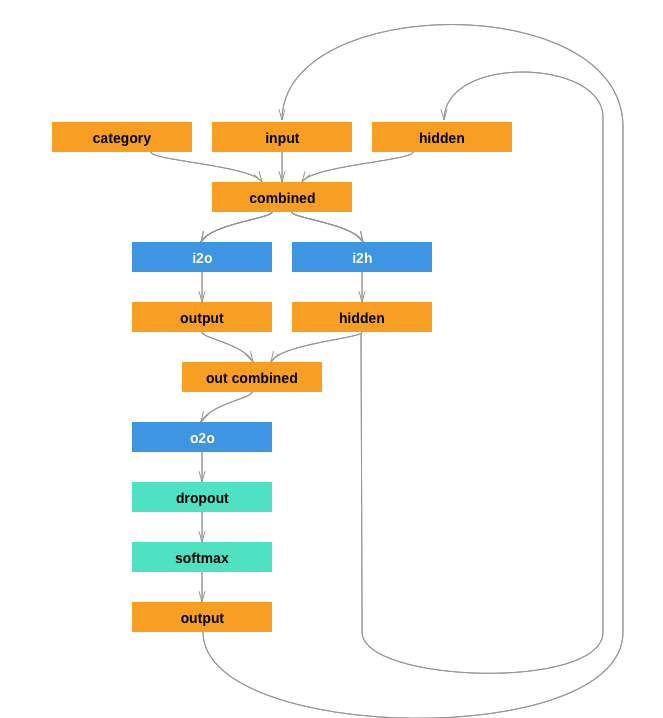

In [41]:
import torch
from torch import nn

In [64]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        
        self.i2h = nn.Linear(category_size + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(category_size + input_size + hidden_size, _size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1) 
        
    def forward(self, category, input, hidden):
        combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        out_combined = torch.cat((hidden, output), 1)
        output = self.o2o(out_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)        

In [79]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [80]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [81]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [82]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로 모든 단계에서 손실을 계산합니다.

Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에 역전파를 호출하게 해줍니다.

In [83]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [84]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [85]:
rnn = RNN(n_letters, 128, n_letters)
category_size = n_categories
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 11s (5000 5%) 3.3705
0m 22s (10000 10%) 2.6703
0m 33s (15000 15%) 2.8799
0m 44s (20000 20%) 3.0390
0m 56s (25000 25%) 2.3734
1m 7s (30000 30%) 2.6442
1m 19s (35000 35%) 2.6847
1m 30s (40000 40%) 2.7212
1m 41s (45000 45%) 2.3218
1m 52s (50000 50%) 1.9724
2m 4s (55000 55%) 2.2114
2m 15s (60000 60%) 2.6455
2m 26s (65000 65%) 2.5744
2m 37s (70000 70%) 2.0488
2m 48s (75000 75%) 1.8710
3m 0s (80000 80%) 2.8164
3m 11s (85000 85%) 1.9748
3m 22s (90000 90%) 2.3926
3m 33s (95000 95%) 1.9748
3m 44s (100000 100%) 2.2838


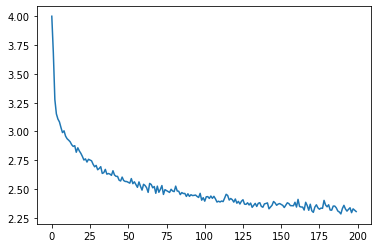

In [86]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [101]:
n_letters

59

## 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고 이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

    입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하십시오
    시작 문자로 output_name 문자열을 생성하십시오
    최대 출력 길이까지,
        현재 문자를 네트워크에 전달하십시오.
        가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻으십시오
        만일 문자가 EOS면, 여기서 멈추십시오
        만일 일반적인 문자라면, output_name 에 추가하고 계속하십시오
    마지막 이름을 반환하십시오

In [114]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1: # n_letters - 1 : 'EOS' token
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
print('-'*10)
samples('German', 'GER')
print('-'*10)
samples('Spanish', 'SPA')
print('-'*10)
samples('Chinese', 'CHI')

Rovan
Uanton
Shavav
----------
Gerter
Eren
Roure
----------
Santa
Parer
Aras
----------
Chan
Hani
Iun


In [115]:
samples('Korean', 'NKL')

Non
Kon
Lon
